In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras import layers, Model
from sklearn.model_selection import train_test_split

from keras import Model
from keras.layers import Conv2D, PReLU,BatchNormalization, Flatten
from keras.layers import UpSampling2D, LeakyReLU, Dense, Input, add
from tqdm import tqdm

In [2]:
train_dir = "PlantVillage" 

for img in os.listdir( train_dir + "/Potato___Early_blight"):
    img_array = cv2.imread(train_dir + "/Potato___Early_blight/" + img)
    
    img_array = cv2.resize(img_array, (128,128))
    lr_img_array = cv2.resize(img_array,(32,32))
    cv2.imwrite(train_dir+ "/hr_images/" + img, img_array)
    cv2.imwrite(train_dir+ "/lr_images/"+ img, lr_img_array)

In [3]:
def res_block(ip):
    
    res_model = Conv2D(64, (3,3), padding = "same")(ip)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    res_model = PReLU(shared_axes = [1,2])(res_model)
    
    res_model = Conv2D(64, (3,3), padding = "same")(res_model)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    
    return add([ip,res_model])

In [4]:
def upscale_block(ip):
    
    up_model = Conv2D(256, (3,3), padding="same")(ip)
    up_model = UpSampling2D( size = 2 )(up_model)
    up_model = PReLU(shared_axes=[1,2])(up_model)
    
    return up_model

In [5]:
def create_gen(gen_ip, num_res_block):
    layers = Conv2D(64, (9,9), padding="same")(gen_ip)
    layers = PReLU(shared_axes=[1,2])(layers)

    temp = layers

    for i in range(num_res_block):
        layers = res_block(layers)

    layers = Conv2D(64, (3,3), padding="same")(layers)
    layers = BatchNormalization(momentum=0.5)(layers)
    layers = add([layers,temp])

    layers = upscale_block(layers)
    layers = upscale_block(layers)

    op = Conv2D(3, (9,9), padding="same")(layers)

    return Model(inputs=gen_ip, outputs=op)


In [6]:
def discriminator_block(ip, filters, strides=1, bn=True):
    
    disc_model = Conv2D(filters, (3,3), strides = strides, padding="same")(ip)
    
    if bn:
        disc_model = BatchNormalization( momentum=0.8 )(disc_model)
    
    disc_model = LeakyReLU( alpha=0.2 )(disc_model)
    
    return disc_model

In [7]:
def create_disc(disc_ip):

    df = 64
    
    d1 = discriminator_block(disc_ip, df, bn=False)
    d2 = discriminator_block(d1, df, strides=2)
    d3 = discriminator_block(d2, df*2)
    d4 = discriminator_block(d3, df*2, strides=2)
    d5 = discriminator_block(d4, df*4)
    d6 = discriminator_block(d5, df*4, strides=2)
    d7 = discriminator_block(d6, df*8)
    d8 = discriminator_block(d7, df*8, strides=2)
    
    d8_5 = Flatten()(d8)
    d9 = Dense(df*16)(d8_5)
    d10 = LeakyReLU(alpha=0.2)(d9)
    validity = Dense(1, activation='sigmoid')(d10)

    return Model(disc_ip, validity)

In [8]:
from tensorflow.keras.applications import VGG19

def build_vgg(hr_shape):
    
    vgg = VGG19(weights="imagenet",include_top=False, input_shape=hr_shape)
    
    return Model(inputs=vgg.inputs, outputs=vgg.layers[10].output)

#Combined model
def create_comb(gen_model, disc_model, vgg, lr_ip, hr_ip):
    gen_img = gen_model(lr_ip)
    
    gen_features = vgg(gen_img)
    
    disc_model.trainable = False
    validity = disc_model(gen_img)
    
    return Model(inputs=[lr_ip, hr_ip], outputs=[validity, gen_features])


In [9]:
n=5000
lr_list = os.listdir("PlantVillage/Potato___Early_blight/")[:n]

lr_images = []
for img in lr_list:
    img_lr = cv2.imread("PlantVillage/lr_images/" + img)
    img_lr = cv2.cvtColor(img_lr, cv2.COLOR_BGR2RGB)
    lr_images.append(img_lr)   


hr_list = os.listdir("PlantVillage/hr_images")[:n]
   
hr_images = []
for img in hr_list:
    img_hr = cv2.imread("PlantVillage/hr_images/" + img)
    img_hr = cv2.cvtColor(img_hr, cv2.COLOR_BGR2RGB)
    hr_images.append(img_hr)   

lr_images = np.array(lr_images)
hr_images = np.array(hr_images)
lr_images

array([[[[192, 189, 210],
         [192, 188, 205],
         [200, 194, 208],
         ...,
         [179, 177, 190],
         [175, 173, 184],
         [184, 182, 193]],

        [[190, 189, 203],
         [186, 184, 195],
         [193, 191, 196],
         ...,
         [180, 178, 191],
         [177, 175, 186],
         [181, 179, 190]],

        [[187, 191, 190],
         [192, 197, 193],
         [187, 190, 179],
         ...,
         [177, 175, 188],
         [179, 177, 188],
         [177, 174, 183]],

        ...,

        [[163, 160, 171],
         [159, 156, 167],
         [169, 166, 177],
         ...,
         [154, 151, 162],
         [155, 153, 166],
         [148, 148, 160]],

        [[164, 164, 172],
         [167, 167, 175],
         [160, 157, 168],
         ...,
         [151, 148, 155],
         [142, 142, 154],
         [149, 151, 164]],

        [[160, 163, 168],
         [163, 164, 169],
         [159, 157, 168],
         ...,
         [149, 148, 153],
        

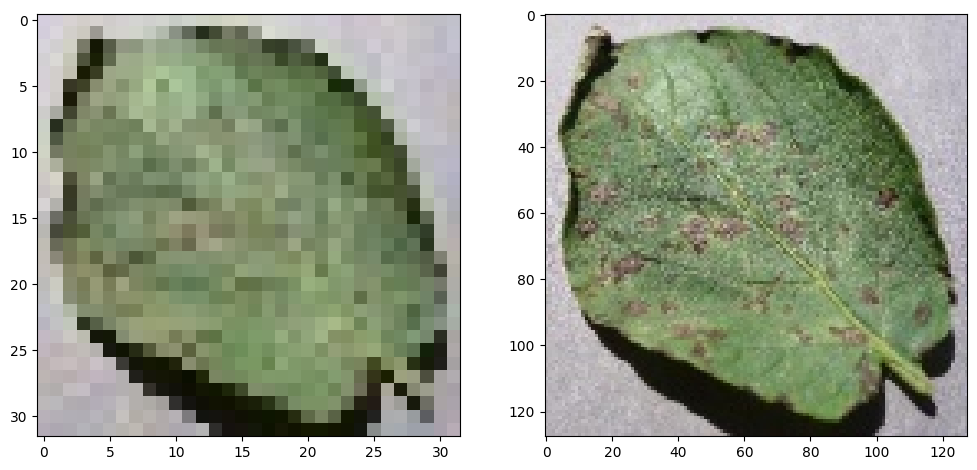

In [10]:
import random
image_number = random.randint(0, len(lr_images)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(lr_images[image_number], (32, 32, 3)))
plt.subplot(122)
plt.imshow(np.reshape(hr_images[image_number], (128, 128, 3)))
plt.show()

In [11]:
lr_images = lr_images / 255.
hr_images = hr_images / 255.

In [12]:
lr_train, lr_test, hr_train, hr_test = train_test_split(lr_images, hr_images, 
                                                      test_size=0.33, random_state=42)

In [13]:
hr_shape = (hr_train.shape[1], hr_train.shape[2], hr_train.shape[3])
lr_shape = (lr_train.shape[1], lr_train.shape[2], lr_train.shape[3])

In [14]:
lr_ip = Input(shape=lr_shape)
hr_ip = Input(shape=hr_shape)

In [15]:
generator = create_gen(lr_ip, num_res_block = 16)
generator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 64)   15616       ['input_1[0][0]']                
                                                                                                  
 p_re_lu (PReLU)                (None, 32, 32, 64)   64          ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 32, 64)   36928       ['p_re_lu[0][0]']                
                                                                                              

In [16]:
discriminator = create_disc(hr_ip)
discriminator.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
discriminator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_37 (Conv2D)          (None, 128, 128, 64)      1792      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128, 128, 64)      0         
                                                                 
 conv2d_38 (Conv2D)          (None, 64, 64, 64)        36928     
                                                                 
 batch_normalization_33 (Bat  (None, 64, 64, 64)       256       
 chNormalization)                                                
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 64, 64, 64)        0         
                                                           

In [17]:
lr_train.shape, hr_train.shape, lr_test.shape, hr_test.shape

((201, 32, 32, 3), (201, 128, 128, 3), (99, 32, 32, 3), (99, 128, 128, 3))

In [18]:
vgg = build_vgg((128,128,3))
print(vgg.summary())
vgg.trainable = False

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0   

In [19]:
gan_model = create_comb(generator, discriminator, vgg, lr_ip, hr_ip)

In [20]:
gan_model.compile(loss=["binary_crossentropy", "mse"], loss_weights=[1e-3, 1], optimizer="adam")
gan_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 model (Functional)             (None, 128, 128, 3)  2044291     ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_1 (Functional)           (None, 1)            38249281    ['model[0][0]']            

In [21]:
batch_size = 1  
train_lr_batches = []
train_hr_batches = []
for it in range(int(hr_train.shape[0] / batch_size)):
    start_idx = it * batch_size
    end_idx = start_idx + batch_size
    train_hr_batches.append(hr_train[start_idx:end_idx])
    train_lr_batches.append(lr_train[start_idx:end_idx])

In [22]:
epochs = 1
#Enumerate training over epochs
for e in range(epochs):
    
    fake_label = np.zeros((batch_size, 1)) # Assign a label of 0 to all fake (generated images)
    real_label = np.ones((batch_size,1)) # Assign a label of 1 to all real images.
    
    #Create empty lists to populate gen and disc losses. 
    g_losses = []
    d_losses = []
    
    #Enumerate training over batches. 
    for b in tqdm(range(len(train_hr_batches))):
        lr_imgs = train_lr_batches[b] #Fetch a batch of LR images for training
        hr_imgs = train_hr_batches[b] #Fetch a batch of HR images for training
        
        fake_imgs = generator.predict_on_batch(lr_imgs) #Fake images
        
        #First, train the discriminator on fake and real HR images. 
        discriminator.trainable = True
        d_loss_gen = discriminator.train_on_batch(fake_imgs, fake_label)
        d_loss_real = discriminator.train_on_batch(hr_imgs, real_label)
        
        #Now, train the generator by fixing discriminator as non-trainable
        discriminator.trainable = False
        
        #Average the discriminator loss, just for reporting purposes. 
        d_loss = 0.5 * np.add(d_loss_gen, d_loss_real) 
        
        #Extract VGG features, to be used towards calculating loss
        image_features = vgg.predict(hr_imgs)
     
        #Train the generator via GAN. 
        #Remember that we have 2 losses, adversarial loss and content (VGG) loss
        g_loss, _, _ = gan_model.train_on_batch([lr_imgs, hr_imgs], [real_label, image_features])
        
        #Save losses to a list so we can average and report. 
        d_losses.append(d_loss)
        g_losses.append(g_loss)
        
    #Convert the list of losses to an array to make it easy to average    
    g_losses = np.array(g_losses)
    d_losses = np.array(d_losses)
    
    #Calculate the average losses for generator and discriminator
    g_loss = np.sum(g_losses, axis=0) / len(g_losses)
    d_loss = np.sum(d_losses, axis=0) / len(d_losses)
    
    #Report the progress during training. 
    print("epoch:", e+1 ,"g_loss:", g_loss, "d_loss:", d_loss)

    if (e+1) % 10 == 0: #Change the frequency for model saving, if needed
        #Save the generator after every n epochs (Usually 10 epochs)
        generator.save("gen_e_"+ str(e+1) +".h5")

  0%|          | 0/201 [00:00<?, ?it/s]

1/1 [==============================] - 1s 814ms/step


  0%|          | 1/201 [02:28<8:14:04, 148.22s/it]

1/1 [==============================] - 0s 432ms/step


  1%|          | 2/201 [02:41<3:47:58, 68.73s/it] 

1/1 [==============================] - 1s 517ms/step


  1%|▏         | 3/201 [02:56<2:25:56, 44.23s/it]

1/1 [==============================] - 0s 220ms/step


  2%|▏         | 4/201 [03:07<1:42:20, 31.17s/it]

1/1 [==============================] - 0s 376ms/step


  2%|▏         | 5/201 [03:18<1:17:42, 23.79s/it]

1/1 [==============================] - 0s 345ms/step


  3%|▎         | 6/201 [03:29<1:03:46, 19.62s/it]

1/1 [==============================] - 0s 442ms/step


  3%|▎         | 7/201 [03:44<58:09, 17.99s/it]  

1/1 [==============================] - 0s 490ms/step


  4%|▍         | 8/201 [03:56<51:53, 16.13s/it]

1/1 [==============================] - 0s 299ms/step


  4%|▍         | 9/201 [04:08<47:11, 14.75s/it]

1/1 [==============================] - 0s 285ms/step


  5%|▍         | 10/201 [04:22<46:24, 14.58s/it]

1/1 [==============================] - 0s 378ms/step


  5%|▌         | 11/201 [04:37<46:12, 14.59s/it]

1/1 [==============================] - 0s 344ms/step


  6%|▌         | 12/201 [04:48<42:30, 13.49s/it]

1/1 [==============================] - 0s 261ms/step


  6%|▋         | 13/201 [05:01<41:55, 13.38s/it]

1/1 [==============================] - 0s 432ms/step


  7%|▋         | 14/201 [05:18<45:05, 14.47s/it]

1/1 [==============================] - 0s 283ms/step


  7%|▋         | 15/201 [05:26<39:28, 12.73s/it]

1/1 [==============================] - 0s 462ms/step


  8%|▊         | 16/201 [05:42<42:00, 13.62s/it]

1/1 [==============================] - 1s 665ms/step


  8%|▊         | 17/201 [05:59<44:50, 14.62s/it]

1/1 [==============================] - 1s 647ms/step


  9%|▉         | 18/201 [06:10<41:28, 13.60s/it]

1/1 [==============================] - 0s 282ms/step


  9%|▉         | 19/201 [06:24<41:41, 13.75s/it]

1/1 [==============================] - 1s 567ms/step


 10%|▉         | 20/201 [06:42<45:08, 14.97s/it]

1/1 [==============================] - 0s 309ms/step


 10%|█         | 21/201 [06:57<44:32, 14.85s/it]

1/1 [==============================] - 0s 346ms/step


 11%|█         | 22/201 [07:12<44:17, 14.85s/it]

1/1 [==============================] - 0s 382ms/step


 11%|█▏        | 23/201 [07:26<43:26, 14.65s/it]

1/1 [==============================] - 0s 439ms/step


 12%|█▏        | 24/201 [07:38<41:04, 13.92s/it]

1/1 [==============================] - 1s 627ms/step


 12%|█▏        | 25/201 [07:49<38:11, 13.02s/it]

1/1 [==============================] - 0s 141ms/step


 13%|█▎        | 26/201 [07:58<34:37, 11.87s/it]

1/1 [==============================] - 0s 226ms/step


 13%|█▎        | 27/201 [08:10<34:29, 11.89s/it]

1/1 [==============================] - 1s 529ms/step


 14%|█▍        | 28/201 [08:23<35:05, 12.17s/it]

1/1 [==============================] - 0s 385ms/step


 14%|█▍        | 29/201 [08:36<35:42, 12.45s/it]

1/1 [==============================] - 0s 432ms/step


 15%|█▍        | 30/201 [08:50<36:35, 12.84s/it]

1/1 [==============================] - 0s 298ms/step


 15%|█▌        | 31/201 [09:04<37:25, 13.21s/it]

1/1 [==============================] - 0s 429ms/step


 16%|█▌        | 32/201 [09:17<37:23, 13.28s/it]

1/1 [==============================] - 0s 268ms/step


 16%|█▋        | 33/201 [09:33<39:34, 14.13s/it]

1/1 [==============================] - 0s 304ms/step


 17%|█▋        | 34/201 [09:48<39:27, 14.18s/it]

1/1 [==============================] - 0s 298ms/step


 17%|█▋        | 35/201 [10:02<39:44, 14.37s/it]

1/1 [==============================] - 0s 319ms/step


 18%|█▊        | 36/201 [10:14<37:32, 13.65s/it]

1/1 [==============================] - 0s 321ms/step


 18%|█▊        | 37/201 [10:28<37:25, 13.69s/it]

1/1 [==============================] - 0s 461ms/step


 19%|█▉        | 38/201 [10:45<39:26, 14.52s/it]

1/1 [==============================] - 0s 298ms/step


 19%|█▉        | 39/201 [11:00<39:42, 14.70s/it]

1/1 [==============================] - 1s 500ms/step


 20%|█▉        | 40/201 [11:13<38:06, 14.20s/it]

1/1 [==============================] - 1s 528ms/step


 20%|██        | 41/201 [11:29<39:34, 14.84s/it]

1/1 [==============================] - 0s 434ms/step


 21%|██        | 42/201 [11:42<37:26, 14.13s/it]

1/1 [==============================] - 0s 315ms/step


 21%|██▏       | 43/201 [11:57<38:18, 14.55s/it]

1/1 [==============================] - 0s 440ms/step


 22%|██▏       | 44/201 [12:10<36:41, 14.02s/it]

1/1 [==============================] - 0s 251ms/step


 22%|██▏       | 45/201 [12:22<34:42, 13.35s/it]

1/1 [==============================] - 0s 266ms/step


 23%|██▎       | 46/201 [12:32<31:50, 12.33s/it]

1/1 [==============================] - 0s 160ms/step


 23%|██▎       | 47/201 [12:39<27:52, 10.86s/it]

1/1 [==============================] - 0s 127ms/step


 24%|██▍       | 48/201 [12:44<23:20,  9.15s/it]

1/1 [==============================] - 0s 115ms/step


 24%|██▍       | 49/201 [12:49<20:01,  7.91s/it]

1/1 [==============================] - 0s 122ms/step


 25%|██▍       | 50/201 [12:54<17:44,  7.05s/it]

1/1 [==============================] - 1s 573ms/step


 25%|██▌       | 51/201 [13:01<17:43,  7.09s/it]

1/1 [==============================] - 0s 136ms/step


 26%|██▌       | 52/201 [13:07<16:05,  6.48s/it]

1/1 [==============================] - 0s 131ms/step


 26%|██▋       | 53/201 [13:11<14:49,  6.01s/it]

1/1 [==============================] - 0s 137ms/step


 27%|██▋       | 54/201 [13:17<14:05,  5.75s/it]

1/1 [==============================] - 1s 591ms/step


 27%|██▋       | 55/201 [13:24<15:20,  6.31s/it]

1/1 [==============================] - 0s 178ms/step


 28%|██▊       | 56/201 [13:30<15:07,  6.26s/it]

1/1 [==============================] - 0s 128ms/step


 28%|██▊       | 57/201 [13:40<17:45,  7.40s/it]

1/1 [==============================] - 0s 326ms/step


 29%|██▉       | 58/201 [13:55<22:57,  9.63s/it]

1/1 [==============================] - 0s 433ms/step


 29%|██▉       | 59/201 [14:08<25:11, 10.64s/it]

1/1 [==============================] - 0s 383ms/step


 30%|██▉       | 60/201 [14:21<26:39, 11.34s/it]

1/1 [==============================] - 0s 342ms/step


 30%|███       | 61/201 [14:35<27:59, 11.99s/it]

1/1 [==============================] - 0s 280ms/step


 31%|███       | 62/201 [14:47<27:39, 11.94s/it]

1/1 [==============================] - 0s 396ms/step


 31%|███▏      | 63/201 [14:57<26:09, 11.37s/it]

1/1 [==============================] - 0s 309ms/step


 32%|███▏      | 64/201 [15:10<27:06, 11.88s/it]

1/1 [==============================] - 0s 325ms/step


 32%|███▏      | 65/201 [15:21<26:28, 11.68s/it]

1/1 [==============================] - 0s 285ms/step


 33%|███▎      | 66/201 [15:33<26:25, 11.74s/it]

1/1 [==============================] - 0s 241ms/step


 33%|███▎      | 67/201 [15:44<25:50, 11.57s/it]

1/1 [==============================] - 0s 121ms/step


 34%|███▍      | 68/201 [15:51<22:46, 10.27s/it]

1/1 [==============================] - 0s 134ms/step


 34%|███▍      | 69/201 [15:56<19:03,  8.66s/it]

1/1 [==============================] - 0s 120ms/step


 35%|███▍      | 70/201 [16:04<18:41,  8.56s/it]

1/1 [==============================] - 0s 339ms/step


 35%|███▌      | 71/201 [16:14<19:23,  8.95s/it]

1/1 [==============================] - 0s 260ms/step


 36%|███▌      | 72/201 [16:27<21:22,  9.94s/it]

1/1 [==============================] - 0s 256ms/step


 36%|███▋      | 73/201 [16:37<21:46, 10.21s/it]

1/1 [==============================] - 0s 267ms/step


 37%|███▋      | 74/201 [16:49<22:50, 10.79s/it]

1/1 [==============================] - 0s 238ms/step


 37%|███▋      | 75/201 [17:01<23:13, 11.06s/it]

1/1 [==============================] - 0s 344ms/step


 38%|███▊      | 76/201 [17:11<22:27, 10.78s/it]

1/1 [==============================] - 0s 298ms/step


 38%|███▊      | 77/201 [17:23<23:03, 11.16s/it]

1/1 [==============================] - 0s 261ms/step


 39%|███▉      | 78/201 [17:35<23:10, 11.30s/it]

1/1 [==============================] - 0s 426ms/step


 39%|███▉      | 79/201 [17:49<24:27, 12.02s/it]

1/1 [==============================] - 0s 343ms/step


 40%|███▉      | 80/201 [17:58<22:26, 11.13s/it]

1/1 [==============================] - 0s 121ms/step


 40%|████      | 81/201 [18:03<18:36,  9.31s/it]

1/1 [==============================] - 1s 514ms/step


 41%|████      | 82/201 [18:08<16:01,  8.08s/it]

1/1 [==============================] - 0s 113ms/step


 41%|████▏     | 83/201 [18:13<14:03,  7.14s/it]

1/1 [==============================] - 0s 116ms/step


 42%|████▏     | 84/201 [18:18<12:34,  6.45s/it]

1/1 [==============================] - 0s 110ms/step


 42%|████▏     | 85/201 [18:26<13:25,  6.95s/it]

1/1 [==============================] - 0s 245ms/step


 43%|████▎     | 86/201 [18:39<16:34,  8.65s/it]

1/1 [==============================] - 0s 360ms/step


 43%|████▎     | 87/201 [18:50<18:12,  9.59s/it]

1/1 [==============================] - 0s 301ms/step


 44%|████▍     | 88/201 [19:01<18:26,  9.80s/it]

1/1 [==============================] - 0s 315ms/step


 44%|████▍     | 89/201 [19:14<20:20, 10.90s/it]

1/1 [==============================] - 0s 228ms/step


 45%|████▍     | 90/201 [19:24<19:33, 10.57s/it]

1/1 [==============================] - 0s 375ms/step


 45%|████▌     | 91/201 [19:38<21:10, 11.55s/it]

1/1 [==============================] - 0s 303ms/step


 46%|████▌     | 92/201 [19:48<20:26, 11.25s/it]

1/1 [==============================] - 0s 400ms/step


 46%|████▋     | 93/201 [20:01<20:58, 11.66s/it]

1/1 [==============================] - 0s 230ms/step


 47%|████▋     | 94/201 [20:13<20:52, 11.71s/it]

1/1 [==============================] - 0s 305ms/step


 47%|████▋     | 95/201 [20:24<20:41, 11.72s/it]

1/1 [==============================] - 0s 269ms/step


 48%|████▊     | 96/201 [20:35<20:02, 11.46s/it]

1/1 [==============================] - 0s 315ms/step


 48%|████▊     | 97/201 [20:45<19:01, 10.98s/it]

1/1 [==============================] - 0s 352ms/step


 49%|████▉     | 98/201 [20:57<19:32, 11.38s/it]

1/1 [==============================] - 0s 313ms/step


 49%|████▉     | 99/201 [21:13<21:35, 12.70s/it]

1/1 [==============================] - 0s 245ms/step


 50%|████▉     | 100/201 [21:30<23:22, 13.88s/it]

1/1 [==============================] - 0s 472ms/step


 50%|█████     | 101/201 [21:41<21:56, 13.16s/it]

1/1 [==============================] - 0s 419ms/step


 51%|█████     | 102/201 [21:58<23:27, 14.21s/it]

1/1 [==============================] - 0s 371ms/step


 51%|█████     | 103/201 [22:12<23:20, 14.29s/it]

1/1 [==============================] - 0s 349ms/step


 52%|█████▏    | 104/201 [22:27<23:01, 14.24s/it]

1/1 [==============================] - 0s 364ms/step


 52%|█████▏    | 105/201 [22:38<21:27, 13.41s/it]

1/1 [==============================] - 0s 164ms/step


 53%|█████▎    | 106/201 [22:48<19:24, 12.26s/it]

1/1 [==============================] - 0s 330ms/step


 53%|█████▎    | 107/201 [23:00<19:12, 12.26s/it]

1/1 [==============================] - 0s 352ms/step


 54%|█████▎    | 108/201 [23:16<20:40, 13.33s/it]

1/1 [==============================] - 0s 372ms/step


 54%|█████▍    | 109/201 [23:30<20:55, 13.64s/it]

1/1 [==============================] - 0s 328ms/step


 55%|█████▍    | 110/201 [23:43<20:21, 13.42s/it]

1/1 [==============================] - 0s 424ms/step


 55%|█████▌    | 111/201 [23:59<21:04, 14.05s/it]

1/1 [==============================] - 0s 470ms/step


 56%|█████▌    | 112/201 [24:13<20:53, 14.09s/it]

1/1 [==============================] - 0s 448ms/step


 56%|█████▌    | 113/201 [24:26<20:25, 13.92s/it]

1/1 [==============================] - 0s 284ms/step


 57%|█████▋    | 114/201 [24:43<21:13, 14.64s/it]

1/1 [==============================] - 0s 384ms/step


 57%|█████▋    | 115/201 [24:58<21:20, 14.89s/it]

1/1 [==============================] - 0s 336ms/step


 58%|█████▊    | 116/201 [25:14<21:27, 15.15s/it]

1/1 [==============================] - 0s 246ms/step


 58%|█████▊    | 117/201 [25:26<19:52, 14.20s/it]

1/1 [==============================] - 0s 394ms/step


 59%|█████▊    | 118/201 [25:38<18:38, 13.48s/it]

1/1 [==============================] - 0s 413ms/step


 59%|█████▉    | 119/201 [25:52<18:37, 13.63s/it]

1/1 [==============================] - 0s 401ms/step


 60%|█████▉    | 120/201 [26:11<20:54, 15.49s/it]

1/1 [==============================] - 0s 400ms/step


 60%|██████    | 121/201 [26:24<19:29, 14.62s/it]

1/1 [==============================] - 0s 280ms/step


 61%|██████    | 122/201 [26:37<18:26, 14.00s/it]

1/1 [==============================] - 0s 494ms/step


 61%|██████    | 123/201 [26:50<17:57, 13.81s/it]

1/1 [==============================] - 0s 343ms/step


 62%|██████▏   | 124/201 [27:03<17:16, 13.46s/it]

1/1 [==============================] - 0s 320ms/step


 62%|██████▏   | 125/201 [27:14<16:16, 12.85s/it]

1/1 [==============================] - 0s 287ms/step


 63%|██████▎   | 126/201 [27:26<15:38, 12.51s/it]

1/1 [==============================] - 0s 300ms/step


 63%|██████▎   | 127/201 [27:36<14:43, 11.94s/it]

1/1 [==============================] - 0s 146ms/step


 64%|██████▎   | 128/201 [27:45<13:15, 10.90s/it]

1/1 [==============================] - 0s 128ms/step


 64%|██████▍   | 129/201 [27:53<12:14, 10.20s/it]

1/1 [==============================] - 0s 199ms/step


 65%|██████▍   | 130/201 [28:00<10:54,  9.21s/it]

1/1 [==============================] - 0s 167ms/step


 65%|██████▌   | 131/201 [28:07<09:49,  8.43s/it]

1/1 [==============================] - 0s 160ms/step


 66%|██████▌   | 132/201 [28:13<09:01,  7.84s/it]

1/1 [==============================] - 0s 257ms/step


 66%|██████▌   | 133/201 [28:20<08:29,  7.49s/it]

1/1 [==============================] - 0s 308ms/step


 67%|██████▋   | 134/201 [28:28<08:36,  7.70s/it]

1/1 [==============================] - 0s 168ms/step


 67%|██████▋   | 135/201 [28:35<08:02,  7.30s/it]

1/1 [==============================] - 0s 170ms/step


 68%|██████▊   | 136/201 [28:41<07:33,  6.98s/it]

1/1 [==============================] - 0s 166ms/step


 68%|██████▊   | 137/201 [28:47<07:06,  6.66s/it]

1/1 [==============================] - 0s 161ms/step


 69%|██████▊   | 138/201 [28:53<06:44,  6.43s/it]

1/1 [==============================] - 0s 164ms/step


 69%|██████▉   | 139/201 [28:59<06:29,  6.28s/it]

1/1 [==============================] - 0s 155ms/step


 70%|██████▉   | 140/201 [29:04<06:16,  6.17s/it]

1/1 [==============================] - 0s 247ms/step


 70%|███████   | 141/201 [29:14<07:02,  7.05s/it]

1/1 [==============================] - 0s 179ms/step


 71%|███████   | 142/201 [29:20<06:40,  6.79s/it]

1/1 [==============================] - 0s 160ms/step


 71%|███████   | 143/201 [29:26<06:22,  6.60s/it]

1/1 [==============================] - 0s 169ms/step


 72%|███████▏  | 144/201 [29:35<06:53,  7.25s/it]

1/1 [==============================] - 0s 157ms/step


 72%|███████▏  | 145/201 [29:41<06:27,  6.92s/it]

1/1 [==============================] - 1s 598ms/step


 73%|███████▎  | 146/201 [29:49<06:38,  7.25s/it]

1/1 [==============================] - 0s 167ms/step


 73%|███████▎  | 147/201 [29:55<06:13,  6.91s/it]

1/1 [==============================] - 0s 156ms/step


 74%|███████▎  | 148/201 [30:01<05:51,  6.63s/it]

1/1 [==============================] - 0s 474ms/step


 74%|███████▍  | 149/201 [30:09<06:04,  7.01s/it]

1/1 [==============================] - 0s 147ms/step


 75%|███████▍  | 150/201 [30:15<05:44,  6.75s/it]

1/1 [==============================] - 0s 187ms/step


 75%|███████▌  | 151/201 [30:23<05:53,  7.06s/it]

1/1 [==============================] - 1s 662ms/step


 76%|███████▌  | 152/201 [30:31<06:00,  7.35s/it]

1/1 [==============================] - 0s 157ms/step


 76%|███████▌  | 153/201 [30:37<05:37,  7.03s/it]

1/1 [==============================] - 0s 157ms/step


 77%|███████▋  | 154/201 [30:43<05:19,  6.79s/it]

1/1 [==============================] - 0s 147ms/step


 77%|███████▋  | 155/201 [30:49<05:00,  6.54s/it]

1/1 [==============================] - 0s 155ms/step


 78%|███████▊  | 156/201 [30:57<05:08,  6.85s/it]

1/1 [==============================] - 1s 676ms/step


 78%|███████▊  | 157/201 [31:05<05:24,  7.38s/it]

1/1 [==============================] - 0s 169ms/step


 79%|███████▊  | 158/201 [31:12<05:06,  7.12s/it]

1/1 [==============================] - 0s 157ms/step


 79%|███████▉  | 159/201 [31:18<04:48,  6.86s/it]

1/1 [==============================] - 0s 182ms/step


 80%|███████▉  | 160/201 [31:25<04:40,  6.85s/it]

1/1 [==============================] - 0s 156ms/step


 80%|████████  | 161/201 [31:31<04:24,  6.62s/it]

1/1 [==============================] - 0s 237ms/step


 81%|████████  | 162/201 [31:39<04:38,  7.15s/it]

1/1 [==============================] - 0s 159ms/step


 81%|████████  | 163/201 [31:46<04:21,  6.88s/it]

1/1 [==============================] - 0s 167ms/step


 82%|████████▏ | 164/201 [31:55<04:36,  7.46s/it]

1/1 [==============================] - 0s 168ms/step


 82%|████████▏ | 165/201 [32:01<04:14,  7.06s/it]

1/1 [==============================] - 1s 607ms/step


 83%|████████▎ | 166/201 [32:09<04:22,  7.49s/it]

1/1 [==============================] - 0s 166ms/step


 83%|████████▎ | 167/201 [32:17<04:16,  7.54s/it]

1/1 [==============================] - 0s 138ms/step


 84%|████████▎ | 168/201 [32:23<03:58,  7.23s/it]

1/1 [==============================] - 1s 728ms/step


 84%|████████▍ | 169/201 [32:32<04:04,  7.63s/it]

1/1 [==============================] - 0s 142ms/step


 85%|████████▍ | 170/201 [32:38<03:43,  7.21s/it]

1/1 [==============================] - 0s 134ms/step


 85%|████████▌ | 171/201 [32:45<03:32,  7.08s/it]

1/1 [==============================] - 0s 153ms/step


 86%|████████▌ | 172/201 [32:52<03:21,  6.96s/it]

1/1 [==============================] - 0s 136ms/step


 86%|████████▌ | 173/201 [32:58<03:09,  6.76s/it]

1/1 [==============================] - 0s 130ms/step


 87%|████████▋ | 174/201 [33:05<03:08,  6.98s/it]

1/1 [==============================] - 1s 631ms/step


 87%|████████▋ | 175/201 [33:13<03:08,  7.24s/it]

1/1 [==============================] - 0s 124ms/step


 88%|████████▊ | 176/201 [33:19<02:50,  6.84s/it]

1/1 [==============================] - 0s 129ms/step


 88%|████████▊ | 177/201 [33:25<02:35,  6.48s/it]

1/1 [==============================] - 0s 134ms/step


 89%|████████▊ | 178/201 [33:30<02:23,  6.24s/it]

1/1 [==============================] - 0s 129ms/step


 89%|████████▉ | 179/201 [33:36<02:14,  6.11s/it]

1/1 [==============================] - 0s 143ms/step


 90%|████████▉ | 180/201 [33:42<02:05,  5.99s/it]

1/1 [==============================] - 0s 133ms/step


 90%|█████████ | 181/201 [33:48<01:57,  5.89s/it]

1/1 [==============================] - 0s 137ms/step


 91%|█████████ | 182/201 [33:53<01:50,  5.83s/it]

1/1 [==============================] - 1s 593ms/step


 91%|█████████ | 183/201 [34:01<01:54,  6.34s/it]

1/1 [==============================] - 0s 142ms/step


 92%|█████████▏| 184/201 [34:07<01:45,  6.21s/it]

1/1 [==============================] - 0s 131ms/step


 92%|█████████▏| 185/201 [34:12<01:37,  6.06s/it]

1/1 [==============================] - 0s 135ms/step


 93%|█████████▎| 186/201 [34:18<01:29,  5.96s/it]

1/1 [==============================] - 0s 130ms/step


 93%|█████████▎| 187/201 [34:24<01:22,  5.90s/it]

1/1 [==============================] - 0s 136ms/step


 94%|█████████▎| 188/201 [34:30<01:16,  5.86s/it]

1/1 [==============================] - 1s 589ms/step


 94%|█████████▍| 189/201 [34:37<01:15,  6.33s/it]

1/1 [==============================] - 0s 131ms/step


 95%|█████████▍| 190/201 [34:43<01:07,  6.14s/it]

1/1 [==============================] - 0s 131ms/step


 95%|█████████▌| 191/201 [34:49<01:00,  6.04s/it]

1/1 [==============================] - 1s 593ms/step


 96%|█████████▌| 192/201 [34:57<00:59,  6.60s/it]

1/1 [==============================] - 0s 139ms/step


 96%|█████████▌| 193/201 [35:02<00:50,  6.37s/it]

1/1 [==============================] - 0s 132ms/step


 97%|█████████▋| 194/201 [35:08<00:43,  6.22s/it]

1/1 [==============================] - 0s 134ms/step


 97%|█████████▋| 195/201 [35:14<00:36,  6.09s/it]

1/1 [==============================] - 0s 141ms/step


 98%|█████████▊| 196/201 [35:20<00:30,  6.01s/it]

1/1 [==============================] - 0s 125ms/step


 98%|█████████▊| 197/201 [35:28<00:26,  6.65s/it]

1/1 [==============================] - 0s 138ms/step


 99%|█████████▊| 198/201 [35:34<00:19,  6.52s/it]

1/1 [==============================] - 0s 140ms/step


 99%|█████████▉| 199/201 [35:40<00:12,  6.38s/it]

1/1 [==============================] - 0s 120ms/step


100%|█████████▉| 200/201 [35:48<00:06,  6.78s/it]

1/1 [==============================] - 1s 914ms/step


100%|██████████| 201/201 [35:56<00:00, 10.73s/it]

epoch: 1 g_loss: 76.46629817450224 d_loss: [3.76418849 0.89303483]


In [24]:
sreeni_lr = cv2.imread("PlantVillage/lr_images/bc8a7fa5-1f77-4829-a1ee-0ccbeef289eb___RS_Early.B 7228.JPG")
sreeni_hr = cv2.imread("PlantVillage/hr_images/b475147c-92bc-419a-b2c3-7d5aabbb79ec___RS_Early.B 7379.JPG")

1/1 [==============================] - 2s 2s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


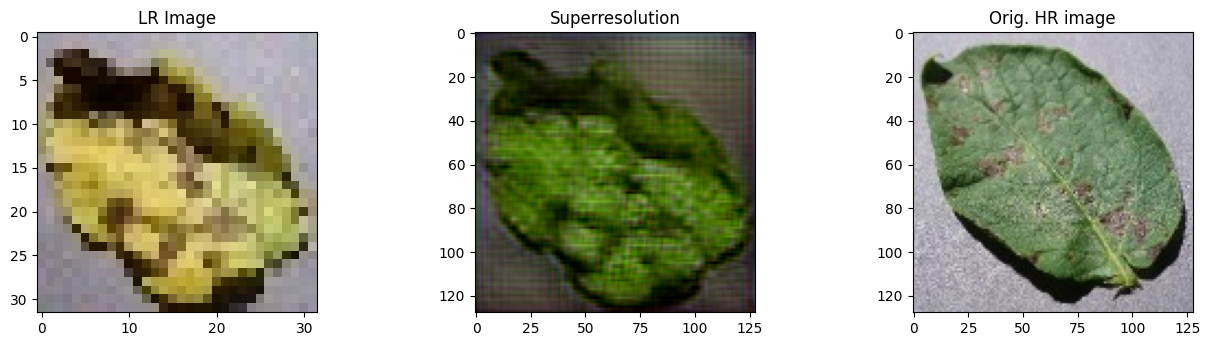

In [25]:
#Change images from BGR to RGB for plotting. 
#Remember that we used cv2 to load images which loads as BGR.
sreeni_lr = cv2.cvtColor(sreeni_lr, cv2.COLOR_BGR2RGB)
sreeni_hr = cv2.cvtColor(sreeni_hr, cv2.COLOR_BGR2RGB)

sreeni_lr = sreeni_lr / 255.
sreeni_hr = sreeni_hr / 255.

sreeni_lr = np.expand_dims(sreeni_lr, axis=0)
sreeni_hr = np.expand_dims(sreeni_hr, axis=0)

generated_sreeni_hr = generator.predict(sreeni_lr)

# plot all three images
plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(sreeni_lr[0,:,:,:])
plt.subplot(232)
plt.title('Superresolution')
plt.imshow(generated_sreeni_hr[0,:,:,:])
plt.subplot(233)
plt.title('Orig. HR image')
plt.imshow(sreeni_hr[0,:,:,:])

plt.show()